In [1]:
%reset # clears variables in workspace

# import libraries
# Pyomo stuff
from pyomo.environ import*
from pyomo.opt import SolverFactory
from pyomo.opt import SolverStatus, TerminationCondition

# other
import sympy as sym
import numpy as np

from IPython.display import display #for pretty printing

import matplotlib.pyplot as plt
import matplotlib.animation as ani
from IPython.display import HTML
%matplotlib inline

# create the model
m = ConcreteModel()

Once deleted, variables cannot be recovered. Proceed (y/[n])? y
Don't know how to reset  #, please run `%reset?` for details
Don't know how to reset  clears, please run `%reset?` for details
Don't know how to reset  variables, please run `%reset?` for details
Flushing input history
Don't know how to reset  workspace, please run `%reset?` for details


In [2]:
N = 30 # how many points are in the trajectory
hm = 0.5/N #scaling factor
m.N = RangeSet(N) # For defining ordered/numerical sets. Works like 'range' in python.

m.g = Param(initialize = 9.81)
m.X0 = Param(initialize = 0.0) # position of fixed base
m.Z0 = Param(initialize = 1.0)
# m.h = Param(initialize = 0.02) # time step

# mass of links
m.m1 = Param(initialize = 0.35)
m.m2 = Param(initialize = 0.15)
m.m3 = Param(initialize = 0.35)
m.m4 = Param(initialize = 0.15)

mbody = m.m1.value+m.m2.value+m.m3.value+m.m4.value
mBW = mbody*m.g.value

# length of links
m.l1 = Param(initialize = 0.12) 
m.l2 = Param(initialize = 0.24) 
m.l3 = Param(initialize = 0.12) 
m.l4 = Param(initialize = 0.24) 
# IMPORTANT make sure your values are declared as floats: many a long debugging session has eventually led me to find something
# unexpectedly has a value of zero because of integer devision gone wrong. Goddamn implicit typing fuuuuuuuuuuuuuuuuuuuuuuuuuuu

#Inertia
m.In1= Param(initialize = m.m1.value*m.l1.value**2/12) 
m.In2= Param(initialize = m.m2.value*m.l2.value**2/12)
m.In3= Param(initialize = m.m3.value*m.l3.value**2/12)
m.In4= Param(initialize = m.m4.value*m.l4.value**2/12)

#Forces
m.t_max=6.864655 #Nm, corresponding to a 8V input
m.w_max=8.055366 #rad/s, corresponding to a 8V input

#Not exactly sure what this is?
m.distance=0.5

print("Done")

Done


In [3]:
# create symbolic variables

# system parameters
g = sym.symbols('g')
m1,m2,m3,m4 = sym.symbols(['m1','m2','m3','m4']) # mass of links
l1,l2,l3,l4 = sym.symbols(['l1','l2','l3','l4']) # length of links
In1,In2,In3,In4 = sym.symbols(['In1','In2','In3','In4']) # moment of intertia of links

# generalized coordinates
x,z,th1,th2,th3,th4 = sym.symbols(['x','z','theta1','theta2','theta3','theta4']) #position
dx,dz,dth1,dth2,dth3,dth4 = sym.symbols(['\dot{x}','\dot{z}','\dot{\\theta}_{1}','\dot{\\theta}_{2}','\dot{\\theta}_{3}','\dot{\\theta}_{4}']) #velocity
ddx,ddz,ddth1,ddth2,ddth3,ddth4 = sym.symbols(['\ddot{x}','\ddot{z}','\ddot{\\theta}_{1}','\ddot{\\theta}_{2}','\ddot{\\theta}_{3}','\ddot{\\theta}_{4}']) #acceleration

q = sym.Matrix([[x],[z],[th1],[th2],[th3],[th4]]) #group into matrices
dq = sym.Matrix([[dx],[dz],[dth1],[dth2],[dth3],[dth4]])
ddq = sym.Matrix([[ddx],[ddz],[ddth1],[ddth2],[ddth3],[ddth4]])

# forces
tau1,tau2,tau3,tau4,GRF1x,GRF1z,GRF2x,GRF2z = sym.symbols(['\\tau_1','\\tau_2','\\tau_3','\\tau_4','G1_x','G1_z','G2_x','G2_z']) 

print('Done')

Done


In [4]:
# STEP 1: position vector (COM of each link) 
#using relative angles 

x1 = x + 0.5*l1*sym.sin(th1)
z1 = z - 0.5*l1*sym.cos(th1)

x2 = x + l1*sym.sin(th1) + 0.5*l2*sym.sin(th1+th2)
z2 = z - l1*sym.cos(th1) - 0.5*l2*sym.cos(th1+th2)

x3 = x + 0.5*l3*sym.sin(th3)
z3 = z - 0.5*l3*sym.cos(th3)

x4 = x + l3*sym.sin(th3) + 0.5*l4*sym.sin(th3+th4)
z4 = z - l3*sym.cos(th3) - 0.5*l4*sym.cos(th3+th4)

foot1x = sym.Matrix([x + l1*sym.sin(th1) + l2*sym.sin(th2)])
foot1z = sym.Matrix([z - l1*sym.cos(th1) - l2*sym.cos(th2)]) 
foot1z = foot1z[0].simplify()
foot1_pos= sym.Matrix([[foot1x],[foot1z]]);

foot2x = sym.Matrix([x + l3*sym.sin(th3) + l4*sym.sin(th4)])
foot2z = sym.Matrix([z - l3*sym.cos(th3) - l4*sym.cos(th4)]) 
foot2z = foot2z[0].simplify()
foot2_pos= sym.Matrix([[foot2x],[foot2z]]);

print('Done')

Done


In [5]:
# STEP 2: generate expressions for the system space velocities
p1 = sym.Matrix([x1,z1])
v1 = p1.jacobian(q)*dq
[dx1,dz1] = v1

p2 = sym.Matrix([x2,z2])
v2 = p2.jacobian(q)*dq
[dx2,dz2] = v2 

p3 = sym.Matrix([x3,z3])
v3 = p3.jacobian(q)*dq
[dx3,dz3] = v3 

p4 = sym.Matrix([x4,z4])
v4 = p4.jacobian(q)*dq
[dx4,dz4] = v3 

foot1dx = foot1x.jacobian(q)*dq #This is symbolic again, so it doesnt change with the collocation
foot1dx = foot1dx[0].simplify()

foot2dx = foot2x.jacobian(q)*dq #This is symbolic again, so it doesnt change with the collocation
foot2dx = foot2dx[0].simplify()

print('Done')

Done


In [6]:
# STEP 3: generate expressions for the kinetic and potential energy

#Stacy Shield's method
# T = sym.Matrix([0.5*m1*(dx1**2+dy1**2) + 0.5*m2*(dx2**2+dy2**2) + 0.5*In1*dth1a**2 + 0.5*In2*dth2a**2])
# V = sym.Matrix([m1*g*y1 + m2*g*y2])

#Callen Fisher's method, better for bigger problems.
M1 = sym.Matrix([[m1,m1]])
M2 = sym.Matrix([[m2,m2]])
M3 = sym.Matrix([[m3,m3]])
M4 = sym.Matrix([[m4,m4]])

I1=sym.Matrix([[In1]])
I2=sym.Matrix([[In2]])
I3=sym.Matrix([[In3]])
I4=sym.Matrix([[In4]])

W1=sym.Matrix([[dth1]])
W2=sym.Matrix([[dth1+dth2]])
W3=sym.Matrix([[dth3]])
W4=sym.Matrix([[dth3+dth4]])

# linear kinetic energy:
Tl = 0.5*M1*sym.matrix_multiply_elementwise(v1,v1) + 0.5*M2*sym.matrix_multiply_elementwise(v2,v2) + 0.5*M3*sym.matrix_multiply_elementwise(v3,v3) + 0.5*M4*sym.matrix_multiply_elementwise(v4,v4)
# angular kinetic energy:
Tw =  0.5*I1*sym.matrix_multiply_elementwise(W1,W1) + 0.5*I2*sym.matrix_multiply_elementwise(W2,W2) + 0.5*I3*sym.matrix_multiply_elementwise(W3,W3) + 0.5*I4*sym.matrix_multiply_elementwise(W4,W4)
#this should be a 3*3 matrix of MOI and a vector of angular vel... w'*MOI*w

T = sym.Matrix([Tl[0]])+sym.Matrix([Tw[0]])
# potential energy
V = m1*g*p1[1] + m2*g*p2[1] + m3*g*p3[1] + m4*g*p4[1]
print('Done')

Done


In [7]:
#Use the manipulator equation to calculate the EoM
#EOM=Mddq+Cdq+G-Q-J.'*GRF ---> Callen's method

M=T.jacobian(dq)
M=M.transpose()
M=M.jacobian(dq)              

C  = sym.zeros(len(q),len(q))                                                         
for i in range(len(q)):                                             
    for j in range(len(q)):
        for n in range(len(q)):
            C[i,j] = C[i,j]+ 0.5*(sym.diff(M[i,j],q[n]) + sym.diff(M[i,n],q[j]) - sym.diff(M[j,n],q[i]))*dq[n];

G  = sym.zeros(len(q),1)                                         
for i in range(len(q)):
    G[i] = sym.diff(V,q[i]);       

Q = sym.zeros(len(q),1)
Q[0]=0                 #x
Q[1]=0                 #z
Q[2]=tau1              #th1
Q[3]=tau2              #th2
Q[4]=tau3              #th3
Q[5]=tau4              #th4


J1=foot1_pos.jacobian(q)
GRF_1 = J1.transpose()*sym.Matrix([[GRF1x],[GRF1z]]) 

J2=foot2_pos.jacobian(q)
GRF_2 = J2.transpose()*sym.Matrix([[GRF2x],[GRF2z]])

EOM=M*ddq+C*dq+G-Q-GRF_1-GRF_2

EOMs = sym.zeros(len(q),1)
for j in range(len(q)):
    EOMs[j] = EOM[j].simplify()  #--> Helps to make simulation faster for bigger problems

#display(EOMs[0])
print('Done')

Done


In [8]:
# Lambdify

func_map = {'sin':sin, 'cos':cos} 

sym_list = [g,m1,m2,m3,m4,l1,l2,l3,l4,
            In1,In2,In3,In4,x,z,th1,th2,th3,th4,
            dx,dz,dth1,dth2,dth3,dth4,ddx,ddz,ddth1,ddth2,
            ddth3,ddth4,tau1,tau2,tau3,tau4,GRF1x,GRF1z,GRF2x,GRF2z]
            
lambEOM_x = sym.lambdify(sym_list,EOMs[0],modules = [func_map])
lambEOM_y = sym.lambdify(sym_list,EOMs[1],modules = [func_map])
lambEOM_th1 = sym.lambdify(sym_list,EOMs[2],modules = [func_map])
lambEOM_th2 = sym.lambdify(sym_list,EOMs[3],modules = [func_map])
lambEOM_th3 = sym.lambdify(sym_list,EOMs[4],modules = [func_map])
lambEOM_th4 = sym.lambdify(sym_list,EOMs[5],modules = [func_map])

lamb_foot1z = sym.lambdify(sym_list,foot1z,modules = [func_map])
lamb_foot1dx = sym.lambdify(sym_list,foot1dx,modules = [func_map])

lamb_foot2z = sym.lambdify(sym_list,foot2z,modules = [func_map])
lamb_foot2dx = sym.lambdify(sym_list,foot2dx,modules = [func_map])

print('Done')

Done


In [9]:
# Variables
cN = 3
m.cN =RangeSet(cN)

links = [('leg',1),('leg',2),('leg',3),('leg',4)]
m.L = Set(dimen=2, initialize=links)

DOFs = ['x','z','theta_1','theta_2','theta_3','theta_4'] # generalized coordinates
m.DOF = Set(initialize = DOFs) 

# system coordinates
#collocation points
m.q = Var(m.N, m.cN, m.DOF) # position
m.dq = Var(m.N, m.cN, m.DOF) # velocity
m.ddq = Var(m.N, m.cN, m.DOF) # acceleration

#nodes
m.q0 = Var(m.N, m.DOF) # position
m.dq0 = Var(m.N, m.DOF) # velocity

#time
m.tt = Var(m.N, m.cN)
m.tt0 = Var(m.N)

m.h = Var(m.N, bounds =(0.1,2.0))

a = [[0.19681547722366, 0.39442431473909, 0.37640306270047],
     [-0.06553542585020, 0.29207341166523, 0.51248582618842],
     [0.02377097434822, -0.04154875212600, 0.11111111111111]]
print('Done')

Done


In [10]:
def ContConstraint_p (m, n, dof):
    if n > 1:
        return m.q0[n,dof] == m.q[n-1,3,dof]
    else:
        return Constraint.Skip
m.ContConstraint_p = Constraint(m.N, m.DOF, rule = ContConstraint_p)

def ContConstraint_v (m, n, dof):
    if n > 1:
        return m.dq0[n,dof] == m.dq[n-1,3,dof]
    else:
        return Constraint.Skip
m.ContConstraint_v = Constraint(m.N, m.DOF, rule = ContConstraint_v)

def ContConstraint_tt (m, n):
    if n > 1:
        return m.tt0[n] == m.tt[n-1,3]
    else:
        return Constraint.Skip
m.ContConstraint_tt = Constraint(m.N, rule = ContConstraint_tt)

print('Done')

Done


In [11]:
def integrate_p(m, n, c, dof): # for positions
    if n > 0:
        return m.q[n,c,dof] == m.q0[n, dof] + hm*m.h[n]*(a[0][c-1]*m.dq[n,1,dof] \
                                                         +a[1][c-1]*m.dq[n,2,dof] \
                                                         +a[2][c-1]*m.dq[n,3,dof])
    else:
        return Constraint.Skip #use this to leave out members of a set that the constraint doesn't apply to
m.integrate_p = Constraint(m.N, m.cN, m.DOF, rule = integrate_p)

def integrate_v(m,n,c,dof): # for velocities
    if n > 0:
        return m.dq[n,c,dof] == m.dq0[n, dof] + hm*m.h[n]*(a[0][c-1]*m.ddq[n,1,dof] \
                                                           +a[1][c-1]*m.ddq[n,2,dof] \
                                                           +a[2][c-1]*m.ddq[n,3,dof])
    else:
        return Constraint.Skip 
m.integrate_v = Constraint(m.N, m.cN, m.DOF, rule = integrate_v)

def integrate_tt(m,n,c): # for time 
    if n > 0:
        return m.tt[n,c] == m.tt0[n] + hm*m.h[n]*(a[0][c-1]+a[1][c-1]+a[2][c-1])
    else:
        return Constraint.Skip 
m.integrate_tt = Constraint(m.N, m.cN, rule = integrate_tt)

print('Done')

Done


In [12]:
signs = ['ps', 'ng']
m.sgn = Set(initialize = ['ps', 'ng'])
WDOFs = ['X','Z','THETA1', 'THETA2','THETA3','THETA4']
m.WDOF = Set(initialize=WDOFs) #change the coordinates
m.GRF1 = Var(m.N, m.cN, m.WDOF, m.sgn, bounds = (0.0,None)) # should bound it to 10*m_robot*g
m.GRF2 = Var(m.N, m.cN, m.WDOF, m.sgn, bounds = (0.0,None)) # should bound it to 10*m_robot*g
m.eps = Param(initialize=1000.0, mutable=True)
m.mu = Param(initialize =1.00)
print('Done')

Done


In [13]:
# SLACK VARIABLES
m.a_contact_1  = Var(m.N, m.cN, bounds = (0.0,None)) 
m.b_contact_1  = Var(m.N, m.cN, bounds = (0.0,None)) 
m.a_friction_1 = Var(m.N, m.cN, bounds = (0.0,None)) 
m.b_friction_1 = Var(m.N, m.cN, bounds = (0.0,None)) 
m.a_slip_p_1   = Var(m.N, m.cN, bounds = (0.0,None)) 
m.b_slip_p_1   = Var(m.N, m.cN, bounds = (0.0,None)) 
m.a_slip_n_1   = Var(m.N, m.cN, bounds = (0.0,None)) 
m.b_slip_n_1   = Var(m.N, m.cN, bounds = (0.0,None)) 
m.gamma_1      = Var(m.N, m.cN, bounds = (0.0,None)) 

m.a_contact_2  = Var(m.N, m.cN, bounds = (0.0,None)) 
m.b_contact_2  = Var(m.N, m.cN, bounds = (0.0,None)) 
m.a_friction_2 = Var(m.N, m.cN, bounds = (0.0,None)) 
m.b_friction_2 = Var(m.N, m.cN, bounds = (0.0,None)) 
m.a_slip_p_2   = Var(m.N, m.cN, bounds = (0.0,None)) 
m.b_slip_p_2   = Var(m.N, m.cN, bounds = (0.0,None)) 
m.a_slip_n_2   = Var(m.N, m.cN, bounds = (0.0,None)) 
m.b_slip_n_2   = Var(m.N, m.cN, bounds = (0.0,None)) 
m.gamma_2      = Var(m.N, m.cN, bounds = (0.0,None)) 
print('Done')

Done


In [14]:
# CONTACT
def def_a_contact_1(m,n,c):   
        var_list = [m.g,m.m1,m.m2,m.m3,m.m4,
            m.l1,m.l2,m.l3,m.l4,m.In1,m.In2,m.In3,m.In4,m.q[n,c,'x'],m.q[n,c,'z'],
            m.q[n,c,'theta_1'],m.q[n,c,'theta_2'],m.q[n,c,'theta_3'],m.q[n,c,'theta_4'],m.dq[n,c,'x'],m.dq[n,c,'z'],
            m.dq[n,c,'theta_1'],m.dq[n,c,'theta_2'],m.dq[n,c,'theta_3'],m.dq[n,c,'theta_4'],m.ddq[n,c,'x'],m.ddq[n,c,'z'],
            m.ddq[n,c,'theta_1'],m.ddq[n,c,'theta_2'],m.ddq[n,c,'theta_3'],m.ddq[n,c,'theta_4'],
            0,0,0,0,0,0,0,0]
        return m.a_contact_1[n,c] == lamb_foot1z(*var_list)
m.def_a_contact_1 = Constraint(m.N, m.cN, rule = def_a_contact_1)
def def_b_contact_1(m,n,c):   
    return m.b_contact_1[n,c] == m.GRF1[n,c,'Z','ps']
m.def_b_contact_1 = Constraint(m.N, m.cN, rule = def_b_contact_1)

def def_a_contact_2(m,n,c):   
        var_list = [m.g,m.m1,m.m2,m.m3,m.m4,
            m.l1,m.l2,m.l3,m.l4,m.In1,m.In2,m.In3,m.In4,m.q[n,c,'x'],m.q[n,c,'z'],
            m.q[n,c,'theta_1'],m.q[n,c,'theta_2'],m.q[n,c,'theta_3'],m.q[n,c,'theta_4'],m.dq[n,c,'x'],m.dq[n,c,'z'],
            m.dq[n,c,'theta_1'],m.dq[n,c,'theta_2'],m.dq[n,c,'theta_3'],m.dq[n,c,'theta_4'],m.ddq[n,c,'x'],m.ddq[n,c,'z'],
            m.ddq[n,c,'theta_1'],m.ddq[n,c,'theta_2'],m.ddq[n,c,'theta_3'],m.ddq[n,c,'theta_4'],
            0,0,0,0,0,0,0,0]
        return m.a_contact_2[n,c] == lamb_foot2z(*var_list)
m.def_a_contact_2 = Constraint(m.N, m.cN, rule = def_a_contact_2)
def def_b_contact_2(m,n,c):   
    return m.b_contact_2[n,c] == m.GRF2[n,c,'Z','ps']
m.def_b_contact_2 = Constraint(m.N, m.cN, rule = def_b_contact_2)

print('Done')

Done


In [15]:
# FRICTION CONE
def def_a_friction_1(m,n,c):   
    return m.a_friction_1[n,c] == m.mu*m.GRF1[n,c,'Z','ps'] - (m.GRF1[n,c,'X','ps'] + m.GRF1[n,c,'X','ng'])
m.def_a_friction_1 = Constraint(m.N, m.cN, rule = def_a_friction_1)
def def_b_friction_1(m,n,c):   
    return m.b_friction_1[n,c] == m.gamma_1[n,c]
m.def_b_friction_1 = Constraint(m.N, m.cN, rule = def_b_friction_1)

def def_a_friction_2(m,n,c):   
    return m.a_friction_2[n,c] == m.mu*m.GRF2[n,c,'Z','ps'] - (m.GRF2[n,c,'X','ps'] + m.GRF2[n,c,'X','ng'])
m.def_a_friction_2 = Constraint(m.N, m.cN, rule = def_a_friction_2)
def def_b_friction_2(m,n,c):   
    return m.b_friction_2[n,c] == m.gamma_2[n,c]
m.def_b_friction_2 = Constraint(m.N, m.cN, rule = def_b_friction_2)

print('Done')

Done


In [16]:
#SLIP POS DIR
def def_a_slip_p_1(m,n,c):   
    var_list = [m.g,m.m1,m.m2,m.m3,m.m4,
            m.l1,m.l2,m.l3,m.l4,m.In1,m.In2,m.In3,m.In4,m.q[n,c,'x'],m.q[n,c,'z'],
            m.q[n,c,'theta_1'],m.q[n,c,'theta_2'],m.q[n,c,'theta_3'],m.q[n,c,'theta_4'],m.dq[n,c,'x'],m.dq[n,c,'z'],
            m.dq[n,c,'theta_1'],m.dq[n,c,'theta_2'],m.dq[n,c,'theta_3'],m.dq[n,c,'theta_4'],m.ddq[n,c,'x'],m.ddq[n,c,'z'],
            m.ddq[n,c,'theta_1'],m.ddq[n,c,'theta_2'],m.ddq[n,c,'theta_3'],m.ddq[n,c,'theta_4'],
            0,0,0,0,0,0,0,0]
    return m.a_slip_p_1[n,c] ==m.gamma_1[n,c]+lamb_foot1dx(*var_list)
m.def_a_slip_p_1 = Constraint(m.N, m.cN, rule = def_a_slip_p_1)
def def_b_slip_p_1(m,n,c):   
    return m.b_slip_p_1[n,c] == m.GRF1[n,c,'X','ps']
m.def_b_slip_p_1 = Constraint(m.N, m.cN, rule = def_b_slip_p_1)

# SLIP NEG DIR
def def_a_slip_n_1(m,n,c):   
    var_list = [m.g,m.m1,m.m2,m.m3,m.m4,
            m.l1,m.l2,m.l3,m.l4,m.In1,m.In2,m.In3,m.In4,m.q[n,c,'x'],m.q[n,c,'z'],
            m.q[n,c,'theta_1'],m.q[n,c,'theta_2'],m.q[n,c,'theta_3'],m.q[n,c,'theta_4'],m.dq[n,c,'x'],m.dq[n,c,'z'],
            m.dq[n,c,'theta_1'],m.dq[n,c,'theta_2'],m.dq[n,c,'theta_3'],m.dq[n,c,'theta_4'],m.ddq[n,c,'x'],m.ddq[n,c,'z'],
            m.ddq[n,c,'theta_1'],m.ddq[n,c,'theta_2'],m.ddq[n,c,'theta_3'],m.ddq[n,c,'theta_4'],
            0,0,0,0,0,0,0,0]
    return m.a_slip_n_1[n,c] ==m.gamma_1[n,c]-lamb_foot1dx(*var_list)
m.def_a_slip_n_1 = Constraint(m.N, m.cN, rule = def_a_slip_n_1)
def def_b_slip_n_1(m,n,c):   
    return m.b_slip_n_1[n,c] == m.GRF1[n,c,'X','ng']
m.def_b_slip_n_1 = Constraint(m.N, m.cN, rule = def_b_slip_n_1)

#SLIP POS DIR
def def_a_slip_p_2(m,n,c):   
    var_list = [m.g,m.m1,m.m2,m.m3,m.m4,
            m.l1,m.l2,m.l3,m.l4,m.In1,m.In2,m.In3,m.In4,m.q[n,c,'x'],m.q[n,c,'z'],
            m.q[n,c,'theta_1'],m.q[n,c,'theta_2'],m.q[n,c,'theta_3'],m.q[n,c,'theta_4'],m.dq[n,c,'x'],m.dq[n,c,'z'],
            m.dq[n,c,'theta_1'],m.dq[n,c,'theta_2'],m.dq[n,c,'theta_3'],m.dq[n,c,'theta_4'],m.ddq[n,c,'x'],m.ddq[n,c,'z'],
            m.ddq[n,c,'theta_1'],m.ddq[n,c,'theta_2'],m.ddq[n,c,'theta_3'],m.ddq[n,c,'theta_4'],
            0,0,0,0,0,0,0,0]
    return m.a_slip_p_2[n,c] ==m.gamma_2[n,c]+lamb_foot2dx(*var_list)
m.def_a_slip_p_2 = Constraint(m.N, m.cN, rule = def_a_slip_p_2)
def def_b_slip_p_2(m,n,c):   
    return m.b_slip_p_2[n,c] == m.GRF2[n,c,'X','ps']
m.def_b_slip_p_2 = Constraint(m.N, m.cN, rule = def_b_slip_p_2)

# SLIP NEG DIR
def def_a_slip_n_2(m,n,c):   
    var_list = [m.g,m.m1,m.m2,m.m3,m.m4,
            m.l1,m.l2,m.l3,m.l4,m.In1,m.In2,m.In3,m.In4,m.q[n,c,'x'],m.q[n,c,'z'],
            m.q[n,c,'theta_1'],m.q[n,c,'theta_2'],m.q[n,c,'theta_3'],m.q[n,c,'theta_4'],m.dq[n,c,'x'],m.dq[n,c,'z'],
            m.dq[n,c,'theta_1'],m.dq[n,c,'theta_2'],m.dq[n,c,'theta_3'],m.dq[n,c,'theta_4'],m.ddq[n,c,'x'],m.ddq[n,c,'z'],
            m.ddq[n,c,'theta_1'],m.ddq[n,c,'theta_2'],m.ddq[n,c,'theta_3'],m.ddq[n,c,'theta_4'],
            0,0,0,0,0,0,0,0]
    return m.a_slip_n_2[n,c] ==m.gamma_2[n,c]-lamb_foot2dx(*var_list)
m.def_a_slip_n_2 = Constraint(m.N, m.cN, rule = def_a_slip_n_2)
def def_b_slip_n_2(m,n,c):   
    return m.b_slip_n_2[n,c] == m.GRF2[n,c,'X','ng']
m.def_b_slip_n_2 = Constraint(m.N, m.cN, rule = def_b_slip_n_2)

print('Done')

Done


In [17]:
#Leg 1
def def_contact_1_pr(m,n):
    a_contact_1_pr = m.a_contact_1[n,1] + m.a_contact_1[n,2] + m.a_contact_1[n,3] 
    b_contact_1_pr = m.b_contact_1[n,1] + m.b_contact_1[n,2] + m.b_contact_1[n,3]  
    return a_contact_1_pr*b_contact_1_pr <= m.eps
m.def_contact_1_pr = Constraint(m.N, rule = def_contact_1_pr)

def def_friction_1_pr(m,n):
    a_friction_1_pr = m.a_friction_1[n,1] + m.a_friction_1[n,2] + m.a_friction_1[n,3] 
    b_friction_1_pr = m.b_friction_1[n,1] + m.b_friction_1[n,2] + m.b_friction_1[n,3]  
    return a_friction_1_pr*b_friction_1_pr <= m.eps
m.def_friction_1_pr = Constraint(m.N, rule = def_friction_1_pr)

def def_slip_p_1_pr(m,n):
    a_slip_p_1_pr = m.a_slip_p_1[n,1] + m.a_slip_p_1[n,2] + m.a_slip_p_1[n,3] 
    b_slip_p_1_pr = m.b_slip_p_1[n,1] + m.b_slip_p_1[n,2] + m.b_slip_p_1[n,3]  
    return a_slip_p_1_pr*b_slip_p_1_pr <= m.eps
m.def_slip_p_1_pr = Constraint(m.N, rule = def_slip_p_1_pr)

def def_slip_n_1_pr(m,n):
    a_slip_n_1_pr = m.a_slip_n_1[n,1] + m.a_slip_n_1[n,2] + m.a_slip_n_1[n,3] 
    b_slip_n_1_pr = m.b_slip_n_1[n,1] + m.b_slip_n_1[n,2] + m.b_slip_n_1[n,3]  
    return a_slip_n_1_pr*b_slip_n_1_pr <= m.eps
m.def_slip_n_1_pr = Constraint(m.N, rule = def_slip_n_1_pr)

#Leg 2
def def_contact_2_pr(m,n):
    a_contact_2_pr = m.a_contact_2[n,1] + m.a_contact_2[n,2] + m.a_contact_2[n,3] 
    b_contact_2_pr = m.b_contact_2[n,1] + m.b_contact_2[n,2] + m.b_contact_2[n,3]  
    return a_contact_2_pr*b_contact_2_pr <= m.eps
m.def_contact_2_pr = Constraint(m.N, rule = def_contact_2_pr)

def def_friction_2_pr(m,n):
    a_friction_2_pr = m.a_friction_2[n,1] + m.a_friction_2[n,2] + m.a_friction_2[n,3] 
    b_friction_2_pr = m.b_friction_2[n,1] + m.b_friction_2[n,2] + m.b_friction_2[n,3]  
    return a_friction_2_pr*b_friction_2_pr <= m.eps
m.def_friction_2_pr = Constraint(m.N, rule = def_friction_2_pr)

def def_slip_p_2_pr(m,n):
    a_slip_p_2_pr = m.a_slip_p_2[n,1] + m.a_slip_p_2[n,2] + m.a_slip_p_2[n,3] 
    b_slip_p_2_pr = m.b_slip_p_2[n,1] + m.b_slip_p_2[n,2] + m.b_slip_p_2[n,3]  
    return a_slip_p_2_pr*b_slip_p_2_pr <= m.eps
m.def_slip_p_2_pr = Constraint(m.N, rule = def_slip_p_2_pr)

def def_slip_n_2_pr(m,n):
    a_slip_n_2_pr = m.a_slip_n_2[n,1] + m.a_slip_n_2[n,2] + m.a_slip_n_2[n,3] 
    b_slip_n_2_pr = m.b_slip_n_2[n,1] + m.b_slip_n_1[n,2] + m.b_slip_n_2[n,3]  
    return a_slip_n_2_pr*b_slip_n_2_pr <= m.eps
m.def_slip_n_2_pr = Constraint(m.N, rule = def_slip_n_2_pr)

print('Done')

Done


In [18]:
m.tau_a = Var(m.N, bounds = (-m.t_max,m.t_max)) # actuator torque at hip_1
m.tau_b = Var(m.N, bounds = (-m.t_max,m.t_max)) # actuator torque at knee_2
m.tau_c = Var(m.N, bounds = (-m.t_max,m.t_max)) # actuator torque at hip_3
m.tau_d = Var(m.N, bounds = (-m.t_max,m.t_max)) # actuator torque at knee_4

def def_hip1_motor_model_p(m,n):
    return  m.tau_a[n] <= m.t_max-m.t_max/m.w_max*(m.dq0[n,'theta_1'])
m.def_hip1_motor_model_p = Constraint(m.N, rule = def_hip1_motor_model_p)
def def_hip1_motor_model_n(m,n):
    return  m.tau_a[n] >= -m.t_max-m.t_max/m.w_max*(m.dq0[n,'theta_1'])
m.def_hip1_motor_model_n = Constraint(m.N, rule = def_hip1_motor_model_n)

def def_knee2_motor_model_p(m,n):
    return  m.tau_b[n] <= m.t_max-m.t_max/m.w_max*(m.dq0[n,'theta_1']-m.dq0[n,'theta_2'])
m.def_knee2_motor_model_p = Constraint(m.N, rule = def_knee2_motor_model_p)
def def_knee2_motor_model_n(m,n):
    return  m.tau_b[n] >= -m.t_max-m.t_max/m.w_max*(m.dq0[n,'theta_1']-m.dq0[n,'theta_2'])
m.def_knee2_motor_model_n = Constraint(m.N, rule = def_knee2_motor_model_n)

def def_hip3_motor_model_p(m,n):
    return  m.tau_c[n] <= m.t_max-m.t_max/m.w_max*(m.dq0[n,'theta_3'])
m.def_hip3_motor_model_p = Constraint(m.N, rule = def_hip3_motor_model_p)
def def_hip3_motor_model_n(m,n):
    return  m.tau_c[n] >= -m.t_max-m.t_max/m.w_max*(m.dq0[n,'theta_3'])
m.def_hip3_motor_model_n = Constraint(m.N, rule = def_hip3_motor_model_n)

def def_knee4_motor_model_p(m,n):
    return  m.tau_d[n] <= m.t_max-m.t_max/m.w_max*(m.dq0[n,'theta_3']-m.dq0[n,'theta_4'])
m.def_knee4_motor_model_p = Constraint(m.N, rule = def_knee4_motor_model_p)
def def_knee4_motor_model_n(m,n):
    return  m.tau_d[n] >= -m.t_max-m.t_max/m.w_max*(m.dq0[n,'theta_3']-m.dq0[n,'theta_4'])
m.def_knee4_motor_model_n = Constraint(m.N, rule = def_knee4_motor_model_n)

print('Done')

Done


In [19]:
from pyomo.environ import*
from pyomo.opt import SolverFactory
from pyomo.opt import SolverStatus, TerminationCondition

S=1.0 #BW/m.mTot    
#Scaling factor, I avoid scaling the problem, others seem to think it works....

def EOM_x(m,n,c):
    tau1_in = S*(m.tau_a[n])
    tau2_in = S*(m.tau_b[n])
    tau3_in = S*(m.tau_c[n])
    tau4_in = S*(m.tau_d[n])
    Gx1_in = S*(m.GRF1[n,c,'X','ps']-m.GRF1[n,c,'X','ng'])
    Gz1_in = S*(m.GRF1[n,c,'Z','ps'])
    Gx2_in = S*(m.GRF2[n,c,'X','ps']-m.GRF2[n,c,'X','ng'])
    Gz2_in = S*(m.GRF2[n,c,'Z','ps'])
    
    var_list = [m.g,m.m1,m.m2,m.m3,m.m4,
            m.l1,m.l2,m.l3,m.l4,m.In1,m.In2,m.In3,m.In4,m.q[n,c,'x'],m.q[n,c,'z'],
            m.q[n,c,'theta_1'],m.q[n,c,'theta_2'],m.q[n,c,'theta_3'],m.q[n,c,'theta_4'],m.dq[n,c,'x'],m.dq[n,c,'z'],
            m.dq[n,c,'theta_1'],m.dq[n,c,'theta_2'],m.dq[n,c,'theta_3'],m.dq[n,c,'theta_4'],m.ddq[n,c,'x'],m.ddq[n,c,'z'],
            m.ddq[n,c,'theta_1'],m.ddq[n,c,'theta_2'],m.ddq[n,c,'theta_3'],m.ddq[n,c,'theta_4'],
            tau1_in,tau2_in,tau3_in,tau4_in,Gx1_in,Gz1_in,Gx2_in,Gz2_in]
    return lambEOM_x(*var_list) == 0
m.EOM_x = Constraint(m.N, m.cN, rule = EOM_x)

def EOM_y(m,n,c):
    tau1_in = S*(m.tau_a[n])
    tau2_in = S*(m.tau_b[n])
    tau3_in = S*(m.tau_c[n])
    tau4_in = S*(m.tau_d[n])
    Gx1_in = S*(m.GRF1[n,c,'X','ps']-m.GRF1[n,c,'X','ng'])
    Gz1_in = S*(m.GRF1[n,c,'Z','ps'])
    Gx2_in = S*(m.GRF2[n,c,'X','ps']-m.GRF2[n,c,'X','ng'])
    Gz2_in = S*(m.GRF2[n,c,'Z','ps'])
    
    var_list = [m.g,m.m1,m.m2,m.m3,m.m4,
            m.l1,m.l2,m.l3,m.l4,m.In1,m.In2,m.In3,m.In4,m.q[n,c,'x'],m.q[n,c,'z'],
            m.q[n,c,'theta_1'],m.q[n,c,'theta_2'],m.q[n,c,'theta_3'],m.q[n,c,'theta_4'],m.dq[n,c,'x'],m.dq[n,c,'z'],
            m.dq[n,c,'theta_1'],m.dq[n,c,'theta_2'],m.dq[n,c,'theta_3'],m.dq[n,c,'theta_4'],m.ddq[n,c,'x'],m.ddq[n,c,'z'],
            m.ddq[n,c,'theta_1'],m.ddq[n,c,'theta_2'],m.ddq[n,c,'theta_3'],m.ddq[n,c,'theta_4'],
            tau1_in,tau2_in,tau3_in,tau4_in,Gx1_in,Gz1_in,Gx2_in,Gz2_in]
    return lambEOM_y(*var_list) == 0
m.EOM_y = Constraint(m.N, m.cN, rule = EOM_y)

def EOM_th1(m,n,c):
    tau1_in = S*(m.tau_a[n])
    tau2_in = S*(m.tau_b[n])
    tau3_in = S*(m.tau_c[n])
    tau4_in = S*(m.tau_d[n])
    Gx1_in = S*(m.GRF1[n,c,'X','ps']-m.GRF1[n,c,'X','ng'])
    Gz1_in = S*(m.GRF1[n,c,'Z','ps'])
    Gx2_in = S*(m.GRF2[n,c,'X','ps']-m.GRF2[n,c,'X','ng'])
    Gz2_in = S*(m.GRF2[n,c,'Z','ps'])
    
    var_list = [m.g,m.m1,m.m2,m.m3,m.m4,
            m.l1,m.l2,m.l3,m.l4,m.In1,m.In2,m.In3,m.In4,m.q[n,c,'x'],m.q[n,c,'z'],
            m.q[n,c,'theta_1'],m.q[n,c,'theta_2'],m.q[n,c,'theta_3'],m.q[n,c,'theta_4'],m.dq[n,c,'x'],m.dq[n,c,'z'],
            m.dq[n,c,'theta_1'],m.dq[n,c,'theta_2'],m.dq[n,c,'theta_3'],m.dq[n,c,'theta_4'],m.ddq[n,c,'x'],m.ddq[n,c,'z'],
            m.ddq[n,c,'theta_1'],m.ddq[n,c,'theta_2'],m.ddq[n,c,'theta_3'],m.ddq[n,c,'theta_4'],
            tau1_in,tau2_in,tau3_in,tau4_in,Gx1_in,Gz1_in,Gx2_in,Gz2_in]
    return lambEOM_th1(*var_list) == 0
m.EOM_th1 = Constraint(m.N, m.cN, rule = EOM_th1)

def EOM_th2(m,n,c):
    tau1_in = S*(m.tau_a[n])
    tau2_in = S*(m.tau_b[n])
    tau3_in = S*(m.tau_c[n])
    tau4_in = S*(m.tau_d[n])
    Gx1_in = S*(m.GRF1[n,c,'X','ps']-m.GRF1[n,c,'X','ng'])
    Gz1_in = S*(m.GRF1[n,c,'Z','ps'])
    Gx2_in = S*(m.GRF2[n,c,'X','ps']-m.GRF2[n,c,'X','ng'])
    Gz2_in = S*(m.GRF2[n,c,'Z','ps'])
    
    var_list = [m.g,m.m1,m.m2,m.m3,m.m4,
            m.l1,m.l2,m.l3,m.l4,m.In1,m.In2,m.In3,m.In4,m.q[n,c,'x'],m.q[n,c,'z'],
            m.q[n,c,'theta_1'],m.q[n,c,'theta_2'],m.q[n,c,'theta_3'],m.q[n,c,'theta_4'],m.dq[n,c,'x'],m.dq[n,c,'z'],
            m.dq[n,c,'theta_1'],m.dq[n,c,'theta_2'],m.dq[n,c,'theta_3'],m.dq[n,c,'theta_4'],m.ddq[n,c,'x'],m.ddq[n,c,'z'],
            m.ddq[n,c,'theta_1'],m.ddq[n,c,'theta_2'],m.ddq[n,c,'theta_3'],m.ddq[n,c,'theta_4'],
            tau1_in,tau2_in,tau3_in,tau4_in,Gx1_in,Gz1_in,Gx2_in,Gz2_in]
    return lambEOM_th2(*var_list) == 0
m.EOM_th2 = Constraint(m.N, m.cN, rule = EOM_th2)

def EOM_th3(m,n,c):
    tau1_in = S*(m.tau_a[n])
    tau2_in = S*(m.tau_b[n])
    tau3_in = S*(m.tau_c[n])
    tau4_in = S*(m.tau_d[n])
    Gx1_in = S*(m.GRF1[n,c,'X','ps']-m.GRF1[n,c,'X','ng'])
    Gz1_in = S*(m.GRF1[n,c,'Z','ps'])
    Gx2_in = S*(m.GRF2[n,c,'X','ps']-m.GRF2[n,c,'X','ng'])
    Gz2_in = S*(m.GRF2[n,c,'Z','ps'])
    
    var_list = [m.g,m.m1,m.m2,m.m3,m.m4,
            m.l1,m.l2,m.l3,m.l4,m.In1,m.In2,m.In3,m.In4,m.q[n,c,'x'],m.q[n,c,'z'],
            m.q[n,c,'theta_1'],m.q[n,c,'theta_2'],m.q[n,c,'theta_3'],m.q[n,c,'theta_4'],m.dq[n,c,'x'],m.dq[n,c,'z'],
            m.dq[n,c,'theta_1'],m.dq[n,c,'theta_2'],m.dq[n,c,'theta_3'],m.dq[n,c,'theta_4'],m.ddq[n,c,'x'],m.ddq[n,c,'z'],
            m.ddq[n,c,'theta_1'],m.ddq[n,c,'theta_2'],m.ddq[n,c,'theta_3'],m.ddq[n,c,'theta_4'],
            tau1_in,tau2_in,tau3_in,tau4_in,Gx1_in,Gz1_in,Gx2_in,Gz2_in]
    return lambEOM_th3(*var_list) == 0
m.EOM_th3= Constraint(m.N, m.cN, rule = EOM_th3)
                      
def EOM_th4(m,n,c):
    tau1_in = S*(m.tau_a[n])
    tau2_in = S*(m.tau_b[n])
    tau3_in = S*(m.tau_c[n])
    tau4_in = S*(m.tau_d[n])
    Gx1_in = S*(m.GRF1[n,c,'X','ps']-m.GRF1[n,c,'X','ng'])
    Gz1_in = S*(m.GRF1[n,c,'Z','ps'])
    Gx2_in = S*(m.GRF2[n,c,'X','ps']-m.GRF2[n,c,'X','ng'])
    Gz2_in = S*(m.GRF2[n,c,'Z','ps'])
    
    var_list = [m.g,m.m1,m.m2,m.m3,m.m4,
            m.l1,m.l2,m.l3,m.l4,m.In1,m.In2,m.In3,m.In4,m.q[n,c,'x'],m.q[n,c,'z'],
            m.q[n,c,'theta_1'],m.q[n,c,'theta_2'],m.q[n,c,'theta_3'],m.q[n,c,'theta_4'],m.dq[n,c,'x'],m.dq[n,c,'z'],
            m.dq[n,c,'theta_1'],m.dq[n,c,'theta_2'],m.dq[n,c,'theta_3'],m.dq[n,c,'theta_4'],m.ddq[n,c,'x'],m.ddq[n,c,'z'],
            m.ddq[n,c,'theta_1'],m.ddq[n,c,'theta_2'],m.ddq[n,c,'theta_3'],m.ddq[n,c,'theta_4'],
            tau1_in,tau2_in,tau3_in,tau4_in,Gx1_in,Gz1_in,Gx2_in,Gz2_in]
    return lambEOM_th4(*var_list) == 0
m.EOM_th4= Constraint(m.N, m.cN, rule = EOM_th4)

print('Done')

Done


In [20]:
def setxBounds(m,n):
    return (-1.0, m.q0[n,'x'], m.distance+1)
m.setxBounds = Constraint(m.N, rule=setxBounds)
def setzBounds(m,n):
    return (0.0, m.q0[n,'z'], 1.0)
m.setzBounds = Constraint(m.N, rule=setzBounds)
def setth1Bounds(m,n):
    return (-3.14, m.q0[n,'theta_1'], 3.14)
m.setth1Bounds = Constraint(m.N, rule=setth1Bounds)
def setth2Bounds(m,n):
    return (-3.14, m.q0[n,'theta_2'], 3.14)
m.setth2Bounds = Constraint(m.N, rule=setth2Bounds)
def setth3Bounds(m,n):
    return (-3.14, m.q0[n,'theta_3'], 3.14)
m.setth3Bounds = Constraint(m.N, rule=setth3Bounds)
def setth4Bounds(m,n):
    return (-3.14, m.q0[n,'theta_4'], 3.14)
m.setth4Bounds = Constraint(m.N, rule=setth4Bounds)

def setdxBounds(m,n):
    return (-1, m.dq0[n,'x'],10)
m.setdxBounds = Constraint(m.N, rule=setdxBounds)
def setdzBounds(m,n):
    return (-10, m.dq0[n,'z'],10)
def setdth1Bounds(m,n):
    return (-m.w_max, m.dq0[n,'theta_1'],m.w_max)
m.setdth1Bounds = Constraint(m.N, rule=setdth1Bounds)
def setdth2Bounds(m,n):
    return (-m.w_max, m.dq0[n,'theta_2'],m.w_max)
m.setdth2Bounds = Constraint(m.N, rule=setdth2Bounds)
def setdth3Bounds(m,n):
    return (-m.w_max, m.dq0[n,'theta_3'], m.w_max)
m.setdth3Bounds = Constraint(m.N, rule=setdth3Bounds)
def setdth4Bounds(m,n):
    return (-m.w_max, m.dq0[n,'theta_4'], m.w_max)
m.setdth4Bounds = Constraint(m.N, rule=setdth4Bounds)

print('Done')

Done


In [21]:
R = 1.0
D = 5.0

Domain = np.linspace(0,D,N)
Range = np.linspace(0,R,N)
for n in range(1,N+1):
    for c in range (1, cN+1): 
        #Randomizing Q Matrix
        m.q[n,c,'x'].value = Domain[n-1] + np.random.uniform(-0.25,0.25)    
        m.q[n,c,'z'].value  = Range[n-1] + np.random.uniform(-0.25,0.25)
        m.q[n,c,'theta_1'].value = np.random.uniform(-np.pi,np.pi)   
        m.q[n,c,'theta_2'].value  = np.random.uniform(-np.pi,np.pi)
        m.q[n,c,'theta_3'].value  = np.random.uniform(-np.pi,np.pi)
        m.q[n,c,'theta_4'].value  = np.random.uniform(-np.pi,np.pi)
        
        #Setting everything else to 0.01
        for dof in DOFs:
            m.dq[n,c , dof].value = 0.01
            m.ddq[n,c , dof].value = 0.01
            
        m.GRF1[n,c,'Z','ps'].value = 0.01
        m.GRF1[n,c,'X','ps'].value = 0.01 
        m.GRF1[n,c,'X','ng'].value = 0.01 
        
        m.GRF2[n,c,'Z','ps'].value = 0.01
        m.GRF2[n,c,'X','ps'].value = 0.01 
        m.GRF2[n,c,'X','ng'].value = 0.01 
        
print('Done')

Done


In [22]:
#constraints for steady-state 
m.q[1,1,'x'].value = 0.0
m.q[1,1,'x'].fixed = True
m.dq[1,1,'z'].value = 0.0
m.dq[1,1,'z'].fixed = True

#Final position constraints
def finalX(m,n):
    if (n==N) :
        return m.q0[n,'x'] >= m.distance
    else:
        return Constraint.Skip
m.finalX = Constraint(m.N, rule = finalX)

def finalZ(m,n):
    if (n==N) :
        return m.q0[n,'z'] == m.q0[1,'z']
    else:
        return Constraint.Skip
m.finalZ = Constraint(m.N, rule = finalZ)

def finalth1(m,n):
    if (n==N) :
        return m.q0[n,'theta_1'] == m.q0[1,'theta_1']
    else:
        return Constraint.Skip
m.finalth1 = Constraint(m.N, rule = finalth1)

def finalth2(m,n):
    if (n==N) :
        return m.q0[n,'theta_2'] == m.q0[1,'theta_2']
    else:
        return Constraint.Skip
m.finalth2 = Constraint(m.N, rule = finalth2)

def finalth3(m,n):
    if (n==N) :
        return m.q0[n,'theta_3'] == m.q0[1,'theta_3']
    else:
        return Constraint.Skip
m.finalth3 = Constraint(m.N, rule = finalth3)

def finalth4(m,n):
    if (n==N) :
        return m.q0[n,'theta_4'] == m.q0[1,'theta_4']
    else:
        return Constraint.Skip
m.finalth4 = Constraint(m.N, rule = finalth4)

#Final velocity constraints
def finaldx(m,n):
    if (n==N) :
        return m.dq0[n,'x'] == m.dq0[1,'x']
    else:
        return Constraint.Skip
m.finaldx = Constraint(m.N, rule = finaldx)

def finaldz(m,n):
    if (n==N) :
        return m.dq0[n,'z'] == m.dq0[1,'z']
    else:
        return Constraint.Skip
m.finaldz = Constraint(m.N, rule = finaldz)

def finaldth1(m,n):
    if (n==N) :
        return m.dq0[n,'theta_1'] == m.dq0[1,'theta_1']
    else:
        return Constraint.Skip
m.finaldth1 = Constraint(m.N, rule = finaldth1)

def finaldth2(m,n):
    if (n==N) :
        return m.dq0[n,'theta_2'] == m.dq0[1,'theta_2']
    else:
        return Constraint.Skip
m.finaldth2 = Constraint(m.N, rule = finaldth2)

def finaldth3(m,n):
    if (n==N) :
        return m.dq0[n,'theta_3'] == m.dq0[1,'theta_3']
    else:
        return Constraint.Skip
m.finaldth3 = Constraint(m.N, rule = finaldth3)


def finaldth4(m,n):
    if (n==N) :
        return m.dq0[n,'theta_4'] == m.dq0[1,'theta_4']
    else:
        return Constraint.Skip
m.finaldth4 = Constraint(m.N, rule = finaldth4)

print('Done')

Done


In [23]:
opt = SolverFactory('ipopt') # standard issue, garden variety ipopt
opt.options["print_level"] = 5 # was 5 # prints a log with each iteration (you want to this - it's the only way to see progress.)
opt.options["max_iter"] = 100000 # maximum number of iterations
opt.options["max_cpu_time"] = 120000 # maximum cpu time in seconds
opt.options["Tol"] = 1e-6 # the tolerance for feasibility. Considers constraints satisfied when they're within this margin.


def CostFun(m):
    return 1 
m.Cost = Objective(rule = CostFun)

#solve once with obj=1
results = opt.solve(m, tee=True)
def CostFun(m):
    return sum(((m.tau_a[n]**2+m.tau_b[n]**2+m.tau_c[n]**2+m.tau_d[n]**2)) for n in range(1,N+1)) #Minimum total actuator force and torque
m.Cost = Objective(rule = CostFun)

#loop solve with proper objective
for i in range(0,4):
    print(m.eps.value)
    if (results.solver.status == SolverStatus.ok) and (results.solver.termination_condition == TerminationCondition.optimal):
        #If the previous solution is optmial, continue solving
        results = opt.solve(m, tee=True)
        m.eps.value = m.eps.value/10
    elif (results.solver.termination_condition == TerminationCondition.infeasible):
        # Break loop when model in infeasible
        break

Ipopt 3.12.13: print_level=5
max_iter=100000
max_cpu_time=120000
Tol=1e-06


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.13, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:    19941
Number of nonzeros in inequality constraint Jacobian.:     2371
Number of nonzeros in Lagrangian Hessian.............:     7559

Total number of variables............................:     4408
                     variables with only lower bounds:     2160
                variables with lower and upper bounds:      150
       

  78  1.0000000e+00 6.06e+00 3.43e+03  -1.0 5.60e+01   1.7 4.08e-03 2.21e-03h  1
  79  1.0000000e+00 6.05e+00 3.07e+03  -1.0 5.19e+01   1.2 2.67e-04 2.47e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  80  1.0000000e+00 6.03e+00 3.83e+03  -1.0 5.29e+01   1.7 3.81e-03 2.36e-03h  1
  81  1.0000000e+00 6.01e+00 3.49e+03  -1.0 4.96e+01   1.2 1.51e-03 4.07e-03f  1
  82  1.0000000e+00 5.99e+00 3.30e+03  -1.0 5.00e+01   1.6 2.13e-03 2.55e-03h  1
  83  1.0000000e+00 5.99e+00 3.42e+03  -1.0 6.49e+01   1.1 2.28e-03 1.71e-04h  1
  84  1.0000000e+00 5.98e+00 2.80e+03  -1.0 4.93e+01   1.6 1.44e-03 3.07e-03h  1
  85  1.0000000e+00 5.96e+00 2.79e+03  -1.0 8.41e+01   1.1 2.45e-03 2.63e-03f  1
  86  1.0000000e+00 5.95e+00 2.83e+03  -1.0 4.95e+01   1.5 2.49e-03 2.35e-03h  1
  87  1.0000000e+00 5.95e+00 4.37e+03  -1.0 4.95e+01   1.9 1.77e-03 9.53e-05h  1
  88  1.0000000e+00 5.94e+00 5.53e+03  -1.0 4.74e+01   1.5 5.50e-03 9.13e-04h  1
  89  1.0000000e+00 5.94e+00

 172  1.0000000e+00 2.82e+00 2.20e+03  -1.0 1.70e+01  -0.1 5.32e-02 3.07e-02f  1
 173  1.0000000e+00 2.68e+00 2.72e+03  -1.0 1.24e+01   0.3 2.24e-02 4.98e-02f  1
 174  1.0000000e+00 2.64e+00 2.95e+02  -1.0 1.22e+01   0.7 6.24e-02 1.45e-02h  1
 175  1.0000000e+00 2.39e+00 8.19e+02  -1.0 1.28e+01   0.3 2.54e-02 9.55e-02f  1
 176  1.0000000e+00 2.27e+00 2.29e+03  -1.0 1.20e+01   0.7 1.21e-01 5.08e-02h  1
 177  1.0000000e+00 2.08e+00 5.27e+03  -1.0 1.16e+01   1.1 1.14e-01 8.56e-02h  1
 178  1.0000000e+00 2.02e+00 5.26e+03  -1.0 1.42e+01   0.6 6.73e-02 2.83e-02f  1
 179  1.0000000e+00 2.00e+00 6.81e+03  -1.0 1.47e+01   1.1 2.93e-02 9.80e-03h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 180  1.0000000e+00 1.94e+00 2.29e+03  -1.0 1.38e+01   1.5 1.40e-02 3.09e-02h  1
 181  1.0000000e+00 1.89e+00 4.68e+03  -1.0 1.69e+01   1.0 6.47e-02 2.24e-02h  1
 182  1.0000000e+00 1.85e+00 5.97e+03  -1.0 1.63e+01   1.4 2.84e-02 2.13e-02h  1
 183  1.0000000e+00 1.64e+00

 265  1.0000000e+00 4.33e-12 8.59e-09  -7.0 1.83e-04  -4.3 1.00e+00 1.00e+00h  1

Number of Iterations....: 265

                                   (scaled)                 (unscaled)
Objective...............:   1.0000000000000000e+00    1.0000000000000000e+00
Dual infeasibility......:   8.5891795306712493e-09    8.5891795306712493e-09
Constraint violation....:   4.3323122866922859e-12    4.3323122866922859e-12
Complementarity.........:   9.0916865017259652e-08    9.0916865017259652e-08
Overall NLP error.......:   9.0916865017259652e-08    9.0916865017259652e-08


Number of objective function evaluations             = 270
Number of objective gradient evaluations             = 262
Number of equality constraint evaluations            = 270
Number of inequality constraint evaluations          = 270
Number of equality constraint Jacobian evaluations   = 267
Number of inequality constraint Jacobian evaluations = 267
Number of Lagrangian Hessian evaluations             = 265
Total CPU secs i

  61  3.2241724e-06 3.98e-06 1.12e-08  -5.7 2.41e+00  -8.3 1.00e+00 1.00e+00h  1
  62  3.2046894e-06 3.59e-05 1.12e-08  -5.7 7.21e+00  -8.8 1.00e+00 1.00e+00h  1
  63  3.1973915e-06 5.05e-06 1.11e-08  -5.7 2.70e+00  -8.4 1.00e+00 1.00e+00h  1
  64  3.1751150e-06 4.55e-05 1.11e-08  -5.7 8.09e+00  -8.9 1.00e+00 1.00e+00h  1
  65  3.1073422e-06 4.11e-04 6.01e-08  -5.7 2.42e+01  -9.3 1.00e+00 1.00e+00h  1
  66  3.0832434e-06 5.77e-05 1.01e-07  -5.7 9.10e+00  -8.9 1.00e+00 1.00e+00h  1
  67  3.0738421e-06 8.33e-06 1.11e-08  -5.7 3.39e+00  -8.5 1.00e+00 1.00e+00h  1
  68  3.0702868e-06 1.15e-06 1.11e-08  -5.7 1.28e+00  -8.1 1.00e+00 1.00e+00h  1
  69  3.0597005e-06 1.03e-05 1.11e-08  -5.7 3.83e+00  -8.5 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  70  3.0284126e-06 9.30e-05 1.35e-08  -5.7 1.15e+01  -9.0 1.00e+00 1.00e+00h  1
  71  3.0168824e-06 1.31e-05 1.11e-08  -5.7 4.30e+00  -8.6 1.00e+00 1.00e+00h  1
  72  3.0125551e-06 1.84e-06

 155  2.4047116e-06 1.03e-06 1.12e-08  -5.7 1.19e+00  -8.0 1.00e+00 1.00e+00h  1
 156  2.3976200e-06 9.25e-06 1.12e-08  -5.7 3.57e+00  -8.5 1.00e+00 1.00e+00h  1
 157  2.3949735e-06 1.30e-06 1.12e-08  -5.7 1.34e+00  -8.1 1.00e+00 1.00e+00h  1
 158  2.3870400e-06 1.17e-05 1.12e-08  -5.7 4.02e+00  -8.6 1.00e+00 1.00e+00h  1
 159  2.3840811e-06 1.65e-06 1.12e-08  -5.7 1.51e+00  -8.1 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 160  2.3752119e-06 1.48e-05 1.12e-08  -5.7 4.52e+00  -8.6 1.00e+00 1.00e+00h  1
 161  2.3719062e-06 2.09e-06 1.12e-08  -5.7 1.70e+00  -8.2 1.00e+00 1.00e+00h  1
 162  2.3619984e-06 1.88e-05 1.12e-08  -5.7 5.09e+00  -8.7 1.00e+00 1.00e+00h  1
 163  2.3325617e-06 1.70e-04 2.04e-08  -5.7 1.53e+01  -9.1 1.00e+00 1.00e+00h  1
 164  2.3217492e-06 2.39e-05 1.12e-08  -5.7 5.73e+00  -8.7 1.00e+00 1.00e+00h  1
 165  2.3176919e-06 3.36e-06 1.12e-08  -5.7 2.15e+00  -8.3 1.00e+00 1.00e+00h  1
 166  2.3161701e-06 4.73e-07

 248  1.7403331e-06 1.92e-06 1.15e-08  -5.7 1.62e+00  -8.1 1.00e+00 1.00e+00h  1
 249  1.7341159e-06 1.73e-05 1.15e-08  -5.7 4.85e+00  -8.6 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 250  1.7156463e-06 1.56e-04 1.34e-08  -5.7 1.46e+01  -9.1 1.00e+00 1.00e+00h  1
 251  1.7088383e-06 2.20e-05 1.15e-08  -5.7 5.47e+00  -8.7 1.00e+00 1.00e+00h  1
 252  1.7062828e-06 3.09e-06 1.15e-08  -5.7 2.05e+00  -8.3 1.00e+00 1.00e+00h  1
 253  1.7053243e-06 4.34e-07 1.15e-08  -5.7 7.69e-01  -7.8 1.00e+00 1.00e+00h  1
 254  1.7024497e-06 3.91e-06 1.15e-08  -5.7 2.31e+00  -8.3 1.00e+00 1.00e+00h  1
 255  1.7013748e-06 5.50e-07 1.15e-08  -5.7 8.65e-01  -7.9 1.00e+00 1.00e+00h  1
 256  1.6981505e-06 4.95e-06 1.15e-08  -5.7 2.60e+00  -8.4 1.00e+00 1.00e+00h  1
 257  1.6885171e-06 4.46e-05 1.15e-08  -5.7 7.79e+00  -8.8 1.00e+00 1.00e+00h  1
 258  1.6599517e-06 4.03e-04 3.35e-08  -5.7 2.34e+01  -9.3 1.00e+00 1.00e+00h  1
 259  1.5769390e-06 3.67e-03

 341  1.0016572e-06 3.73e-06 1.20e-08  -5.7 2.24e+00  -8.3 1.00e+00 1.00e+00h  1
 342  9.9741828e-07 3.36e-05 1.20e-08  -5.7 6.73e+00  -8.7 1.00e+00 1.00e+00h  1
 343  9.9584302e-07 4.73e-06 1.20e-08  -5.7 2.52e+00  -8.3 1.00e+00 1.00e+00h  1
 344  9.9525281e-07 6.65e-07 1.21e-08  -5.7 9.47e-01  -7.9 1.00e+00 1.00e+00h  1
 345  9.9348061e-07 5.98e-06 1.21e-08  -5.7 2.84e+00  -8.4 1.00e+00 1.00e+00h  1
 346  9.9281821e-07 8.41e-07 1.21e-08  -5.7 1.07e+00  -7.9 1.00e+00 1.00e+00h  1
 347  9.9083199e-07 7.58e-06 1.21e-08  -5.7 3.20e+00  -8.4 1.00e+00 1.00e+00h  1
 348  9.9009001e-07 1.07e-06 1.21e-08  -5.7 1.20e+00  -8.0 1.00e+00 1.00e+00h  1
 349  9.8786544e-07 9.59e-06 1.21e-08  -5.7 3.60e+00  -8.5 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 350  9.8703476e-07 1.35e-06 1.21e-08  -5.7 1.35e+00  -8.0 1.00e+00 1.00e+00h  1
 351  9.8454435e-07 1.22e-05 1.21e-08  -5.7 4.05e+00  -8.5 1.00e+00 1.00e+00h  1
 352  9.8361482e-07 1.71e-06

Number of inequality constraint evaluations          = 467
Number of equality constraint Jacobian evaluations   = 431
Number of inequality constraint Jacobian evaluations = 431
Number of Lagrangian Hessian evaluations             = 430
Total CPU secs in IPOPT (w/o function evaluations)   =    155.105
Total CPU secs in NLP function evaluations           =      3.054

EXIT: Optimal Solution Found.
100.0
Ipopt 3.12.13: print_level=5
max_iter=100000
max_cpu_time=120000
Tol=1e-06


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.13, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt docu

  73  2.7009590e+02 3.52e+01 9.38e+04  -1.0 4.37e+01  -0.2 5.33e-02 3.21e-02h  1
  74  2.7096437e+02 3.45e+01 9.25e+04  -1.0 4.34e+01   0.2 4.31e-02 1.82e-02h  1
  75  2.7263181e+02 3.36e+01 8.80e+04  -1.0 9.01e+01  -0.3 4.29e-02 2.65e-02h  1
  76  2.7302230e+02 3.33e+01 8.71e+04  -1.0 5.29e+01   0.1 5.39e-03 8.39e-03h  1
  77  2.7715074e+02 2.94e+01 8.58e+04  -1.0 1.11e+02  -0.3 4.93e-02 1.18e-01h  1
  78  2.7768036e+02 2.88e+01 8.57e+04  -1.0 3.33e+01   0.1 1.11e-03 2.12e-02h  1
  79  2.7866057e+02 2.77e+01 8.45e+04  -1.0 2.86e+01   0.5 5.20e-02 3.78e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  80  2.8003388e+02 2.53e+01 8.64e+04  -1.0 2.71e+01   0.0 1.48e-02 8.52e-02h  1
  81  2.8007556e+02 2.53e+01 8.67e+04  -1.0 2.42e+01   0.5 1.74e-02 3.55e-03h  1
  82  2.8039079e+02 2.28e+01 8.36e+04  -1.0 2.29e+01  -0.0 6.35e-02 9.66e-02h  1
  83  2.8059476e+02 2.23e+01 8.10e+04  -1.0 1.84e+01   0.4 9.78e-02 2.42e-02h  1
  84  2.8048078e+02 2.08e+01

 167  9.6561883e-01 4.83e-01 2.65e-02  -1.7 9.97e+01  -6.2 1.00e+00 1.00e+00h  1
 168  9.5779148e-01 4.58e-01 7.52e-02  -1.7 1.81e+02  -6.7 1.00e+00 1.00e+00h  1
 169  9.2380980e-01 3.15e-01 1.19e-01  -1.7 2.47e+02  -7.2 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 170  8.6058284e-01 1.06e+00 6.49e-02  -1.7 4.72e+02  -7.7 1.00e+00 1.00e+00h  1
 171  8.0678806e-01 1.40e+00 6.27e-02  -1.7 8.58e+02  -8.2 1.00e+00 1.00e+00h  1
 172  7.7453253e-01 3.74e+00 5.70e-02  -1.7 1.53e+03  -8.6 1.00e+00 1.00e+00h  1
 173  7.7895682e-01 5.53e+00 3.71e-02  -1.7 4.83e+03  -9.1 1.00e+00 1.00e+00H  1
 174  8.1494393e-01 4.34e-01 5.33e-03  -1.7 5.18e+02  -9.6 1.00e+00 1.00e+00h  1
 175  8.1690348e-01 8.43e-03 1.31e-04  -1.7 5.94e+01 -10.1 1.00e+00 1.00e+00h  1
 176  3.1544690e-01 5.22e+01 1.17e+00  -3.8 4.47e+03 -10.5 4.66e-01 7.33e-01f  1
 177  9.3119389e-02 1.05e+00 3.42e-01  -3.8 4.31e+02 -11.5 7.80e-01 1.00e+00h  1
 178  3.3223796e-02 1.47e+00

  27  1.4548687e+01 1.97e+01 5.08e+04  -1.0 7.03e+00   1.1 1.05e-01 3.14e-02h  1
  28  1.4620883e+01 1.94e+01 5.01e+04  -1.0 9.77e+00   0.7 3.83e-03 1.49e-02h  1
  29  1.4634290e+01 1.94e+01 5.67e+04  -1.0 9.87e+00   1.1 5.09e-02 2.64e-03h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  1.4730056e+01 1.86e+01 5.46e+04  -1.0 1.29e+01   0.6 5.72e-03 4.13e-02h  1
  31  1.4800912e+01 1.83e+01 5.25e+04  -1.0 1.13e+01   1.0 8.56e-03 1.64e-02h  1
  32  1.4987176e+01 1.76e+01 5.17e+04  -1.0 1.14e+01   0.6 8.95e-03 3.50e-02h  1
  33  1.5101697e+01 1.73e+01 5.28e+04  -1.0 1.01e+01   1.0 3.95e-02 1.62e-02h  1
  34  1.5149844e+01 1.63e+01 4.72e+04  -1.0 1.17e+01   0.5 1.00e-01 5.91e-02h  1
  35  1.5333989e+01 1.59e+01 4.52e+04  -1.0 8.91e+00   0.9 1.37e-02 2.81e-02h  1
  36  1.4977551e+01 1.58e+01 4.51e+04  -1.0 1.01e+02   0.5 3.00e-03 3.89e-03h  1
  37  1.5130258e+01 1.55e+01 4.56e+04  -1.0 8.85e+00   0.9 6.94e-02 1.91e-02h  1
  38  1.5280365e+01 1.52e+01

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120  2.6996438e+01 4.36e+00 1.77e+07  -1.0 8.55e+00   3.7 2.23e-02 3.14e-04h  1
 121  2.7000536e+01 4.34e+00 1.75e+07  -1.0 2.09e+01   3.3 4.07e-03 5.94e-03h  1
 122  2.7002688e+01 4.34e+00 2.05e+07  -1.0 8.68e+00   3.7 1.41e-02 6.31e-04h  1
 123  2.7025272e+01 4.30e+00 2.02e+07  -1.0 1.12e+01   3.2 3.56e-03 7.34e-03h  1
 124  2.7025331e+01 4.30e+00 2.01e+07  -1.0 2.74e+01   2.7 3.50e-03 3.79e-04h  1
 125  2.7046546e+01 4.28e+00 2.07e+07  -1.0 1.03e+01   3.2 1.93e-02 4.63e-03h  1
 126  2.7075768e+01 4.23e+00 2.05e+07  -1.0 6.02e+01   2.7 4.25e-03 1.33e-02h  1
 127  2.7129935e+01 4.17e+00 2.06e+07  -1.0 1.36e+01   3.1 2.33e-02 1.25e-02h  1
 128  2.7133726e+01 4.17e+00 2.65e+07  -1.0 8.69e+00   3.5 3.92e-02 8.32e-04h  1
 129  2.7328763e+01 3.98e+00 2.46e+07  -1.0 1.24e+01   3.0 7.67e-03 4.46e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 130  2.7342446e+01 3.97e+00

 213  2.6677587e+01 4.39e-01 5.90e+01  -1.7 3.13e+00  -2.2 4.63e-01 9.52e-01f  1
 214  2.3586887e+01 2.64e-01 2.03e+01  -1.7 5.09e+00  -2.7 5.71e-01 4.24e-01f  1
 215  2.0425677e+01 1.10e-01 5.39e+00  -1.7 4.39e+00  -2.3 6.66e-01 5.90e-01f  1
 216  1.8259445e+01 8.31e-02 4.32e+00  -1.7 1.13e+01  -2.8 2.45e-01 2.70e-01f  1
 217  1.6033251e+01 6.61e-02 4.29e+00  -1.7 2.00e+01  -3.2 1.78e-01 2.33e-01f  1
 218  1.4294339e+01 4.25e-02 4.83e+00  -1.7 5.67e+00  -2.8 1.00e+00 3.69e-01h  1
 219  1.3764355e+01 4.31e-02 5.82e+00  -1.7 2.76e+01  -3.3 4.15e-01 8.96e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 220  1.1188227e+01 4.68e-02 3.01e-01  -1.7 4.74e+00  -2.9 1.00e+00 1.00e+00h  1
 221  1.0183895e+01 1.55e-01 2.07e-01  -1.7 3.03e+01  -3.3 3.47e-01 3.22e-01h  1
 222  9.5578494e+00 7.30e-02 8.12e-01  -1.7 4.61e+00  -2.9 1.00e+00 5.85e-01h  1
 223  8.8579375e+00 2.39e-02 3.11e-01  -1.7 1.38e+01  -3.4 1.00e+00 1.00e+00h  1
 224  8.4880440e+00 3.34e-02

 306  2.5224491e-02 8.67e-04 3.78e-05  -3.8 4.15e+00  -6.0 1.00e+00 1.00e+00h  1
 307  2.4899756e-02 2.16e-03 2.39e-05  -3.8 1.09e+01  -6.4 1.00e+00 1.00e+00h  1
 308  2.4270202e-02 1.18e-02 1.20e-04  -3.8 3.31e+01  -6.9 1.00e+00 1.00e+00h  1
 309  2.2672246e-02 1.34e-02 6.68e-03  -3.8 1.12e+02  -7.4 1.00e+00 7.25e-01H  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 310  2.2535869e-02 1.28e-01 7.53e-03  -3.8 7.22e+01  -7.9 9.01e-01 1.00e+00h  1
 311  2.2517722e-02 6.55e-02 1.70e-04  -3.8 1.08e+02  -8.4 1.00e+00 1.00e+00h  1
 312  2.2730406e-02 8.28e-01 2.25e-03  -3.8 1.08e+03  -8.8 3.77e-01 3.11e-01h  2
 313  2.2831882e-02 7.08e-01 1.15e-02  -3.8 3.25e+02  -8.4 4.53e-01 2.52e-01h  2
 314  2.2667000e-02 5.78e-02 2.07e-04  -3.8 8.70e+01  -8.0 1.00e+00 1.00e+00h  1
 315  2.2899812e-02 2.53e-01 1.14e-03  -3.8 3.53e+02  -8.5 9.72e-01 1.00e+00h  1
 316  2.3002513e-02 9.59e-03 6.83e-04  -3.8 2.07e+00  -5.3 1.00e+00 9.63e-01h  1
 317  2.2631973e-02 3.42e-03

 399  2.5084014e-07 2.46e-04 1.74e-08  -7.0 2.33e+00  -9.7 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 400  2.4097863e-07 1.45e-03 1.22e-06  -7.0 4.99e+00 -10.2 1.00e+00 1.00e+00h  1
 401  2.2636275e-07 3.95e-03 9.07e-08  -7.0 9.59e+00 -10.7 1.00e+00 1.00e+00h  1
 402  2.1137243e-07 8.52e-04 5.06e-08  -7.0 1.68e+01 -11.1 1.00e+00 1.00e+00h  1
 403  2.1153724e-07 3.91e-06 1.27e-09  -7.0 3.17e-01  -9.4 1.00e+00 1.00e+00h  1
 404  2.1104435e-07 9.34e-06 5.59e-07  -7.0 9.00e-01  -9.9 1.00e+00 1.00e+00h  1
 405  2.0897201e-07 3.24e-05 4.31e-09  -7.0 2.45e+00 -10.3 1.00e+00 1.00e+00h  1
 406  2.0419235e-07 1.39e-03 1.13e-05  -7.0 6.79e+00 -10.8 1.00e+00 1.00e+00h  1
 407  1.9985710e-07 1.26e-03 5.16e-08  -7.0 1.17e+01 -11.3 1.00e+00 1.00e+00h  1
 408  1.9873440e-07 3.53e-04 4.48e-09  -7.0 5.13e+00 -10.9 1.00e+00 1.00e+00h  1
 409  1.9845881e-07 1.83e-03 8.82e-06  -7.0 3.37e+01 -11.3 1.00e+00 2.50e-01h  3
iter    objective    inf_pr 

  41  4.2930681e+00 6.17e+00 9.05e+03  -1.0 1.83e+02  -0.3 7.04e-03 5.78e-03h  1
  42  4.3991904e+00 6.15e+00 1.09e+04  -1.0 3.31e+02  -0.8 4.57e-03 3.43e-03h  1
  43  4.6009445e+00 6.11e+00 1.44e+03  -1.0 2.12e+02  -0.4 3.44e-03 6.49e-03h  1
  44  4.7207108e+00 6.10e+00 1.56e+03  -1.0 5.43e+02  -0.8 3.07e-03 2.64e-03h  1
  45  4.7254125e+00 6.10e+00 4.64e+03  -1.0 1.04e+03  -1.3 4.09e-03 1.50e-04h  1
  46  4.8303874e+00 6.08e+00 7.21e+03  -1.0 3.31e+02  -0.9 4.45e-03 2.16e-03h  1
  47  5.4516909e+00 6.03e+00 2.72e+03  -1.0 9.26e+02  -1.4 2.61e-03 8.39e-03h  1
  48  5.5500490e+00 6.02e+00 8.24e+03  -1.0 4.85e+02  -0.9 5.16e-03 1.53e-03h  1
  49  5.5667701e+00 6.02e+00 1.11e+04  -1.0 9.07e+02  -1.4 3.04e-03 5.13e-04h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50  5.9005554e+00 5.99e+00 6.87e+03  -1.0 5.49e+02  -1.0 2.86e-03 4.89e-03h  1
  51  5.8717042e+00 5.98e+00 7.31e+03  -1.0 2.08e+03  -1.5 1.50e-03 1.18e-03h  1
  52  5.9017938e+00 5.98e+00

 134  1.7748396e+01 3.79e+00 3.90e+03  -1.0 7.14e+03 -12.1 2.72e-03 1.12e-02f  1
 135  1.8752777e+01 3.75e+00 3.58e+03  -1.0 6.22e+03 -12.6 1.78e-02 1.01e-02f  1
 136  2.0389371e+01 3.68e+00 3.68e+03  -1.0 6.84e+03 -13.1 1.28e-02 1.62e-02f  1
 137  2.4956999e+01 3.51e+00 6.48e+03  -1.0 7.03e+03 -13.6 1.07e-02 4.36e-02f  1
 138  2.6214866e+01 3.45e+00 6.45e+03  -1.0 3.97e+03 -14.0 1.28e-02 1.41e-02f  1
 139  2.8779721e+01 3.33e+00 6.65e+03  -1.0 3.75e+03 -14.5 1.92e-02 2.92e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 140  2.9732221e+01 3.27e+00 6.74e+03  -1.0 2.71e+03 -15.0 3.83e-03 1.21e-02f  1
 141  3.3301190e+01 3.05e+00 7.06e+03  -1.0 2.10e+03 -15.5 9.08e-03 4.16e-02f  1
 142  3.6938942e+01 2.74e+00 7.24e+03  -1.0 8.87e+03 -16.0 8.34e-03 3.84e-02f  1
 143  3.8226659e+01 2.58e+00 6.89e+03  -1.0 2.19e+03 -16.4 4.99e-02 1.63e-02f  1
 144  4.6177556e+01 1.82e+00 6.55e+03  -1.0 2.45e+03 -16.9 1.76e-02 9.56e-02f  1
 145  4.9111281e+01 1.74e+00

 227  1.8008916e+02 3.41e-01 2.50e+06  -1.0 1.46e+02   0.1 1.05e-03 1.22e-03h  1
 228  1.8306140e+02 3.24e-01 2.27e+06  -1.0 2.02e+02  -0.4 2.90e-02 4.94e-02h  1
 229  1.8318464e+02 3.23e-01 2.69e+06  -1.0 1.28e+02   0.0 2.18e-02 2.45e-03h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 230  1.8345293e+02 3.21e-01 2.67e+06  -1.0 2.24e+02  -0.5 3.92e-03 5.44e-03h  1
 231  1.8351977e+02 3.21e-01 2.72e+06  -1.0 1.21e+02  -0.0 4.47e-03 1.50e-03h  1
 232  1.8412917e+02 3.17e-01 2.67e+06  -1.0 2.76e+02  -0.5 1.88e-03 1.21e-02h  1
 233  1.8430225e+02 3.16e-01 2.72e+06  -1.0 1.21e+02  -0.1 7.64e-03 3.62e-03h  1
 234  1.8514998e+02 3.10e-01 2.02e+06  -1.0 1.19e+02   0.3 4.92e-03 1.81e-02h  1
 235  1.8629192e+02 3.02e-01 1.75e+06  -1.0 1.19e+02  -0.1 5.47e-03 2.44e-02h  1
 236  1.8637082e+02 3.02e-01 3.48e+06  -1.0 1.11e+02   0.3 4.47e-02 1.80e-03h  1
 237  1.8728503e+02 2.96e-01 3.29e+06  -1.0 1.27e+02  -0.2 1.03e-03 1.89e-02h  1
 238  1.8738719e+02 2.95e-01

 321  2.1182121e+02 7.18e-02 6.72e+07  -1.0 5.45e+01   1.3 1.90e-02 8.21e-02h  1
 322  2.1184398e+02 7.17e-02 7.44e+07  -1.0 4.05e+01   1.7 3.16e-02 1.99e-03h  1
 323  2.1187208e+02 7.15e-02 7.40e+07  -1.0 5.36e+01   1.2 6.99e-03 2.37e-03h  1
 324  2.1265668e+02 6.66e-02 5.81e+07  -1.0 4.02e+01   1.6 2.46e-03 6.85e-02h  1
 325  2.1273261e+02 6.62e-02 5.26e+07  -1.0 6.09e+01   1.2 7.09e-02 6.82e-03h  1
 326  2.1356414e+02 6.11e-02 4.40e+07  -1.0 3.94e+01   1.6 3.24e-02 7.65e-02h  1
 327  2.1357409e+02 6.10e-02 4.39e+07  -1.0 1.14e+02   1.1 7.03e-04 2.19e-03h  1
 328  2.1360515e+02 6.07e-02 4.36e+07  -1.0 3.80e+01   1.5 2.45e-04 3.91e-03h  1
 329  2.1404217e+02 5.74e-02 2.90e+07  -1.0 3.32e+01   2.0 2.83e-02 5.55e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 330  2.1404509e+02 5.73e-02 2.89e+07  -1.0 3.92e+01   1.5 4.29e-04 3.77e-04h  1
 331  2.1404625e+02 5.73e-02 4.70e+07  -1.0 3.48e+01   1.9 5.20e-02 1.34e-04h  1
 332  2.1406527e+02 5.72e-02

 416  1.2891403e+02 1.27e-04 2.34e+01  -2.5 2.93e+01  -2.5 1.83e-02 1.11e-01f  1
 417  1.2852538e+02 1.84e-05 3.39e-01  -2.5 4.28e-01  -1.2 1.00e+00 1.00e+00f  1
 418  1.2835593e+02 1.48e-04 1.63e+02  -2.5 1.51e+00  -1.7 6.65e-01 1.70e-01f  1
 419  1.2806688e+02 3.97e-05 1.14e+02  -2.5 4.55e+00  -2.1 2.49e-01 2.11e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 420  1.2758046e+02 9.62e-05 4.85e+01  -2.5 1.52e+00  -1.7 6.72e-01 8.08e-01f  1
 421  1.2728666e+02 1.55e-04 6.41e+01  -2.5 6.41e+00  -2.2 2.01e-01 9.97e-02f  1
 422  1.2665585e+02 1.37e-03 1.42e+02  -2.5 1.60e+01  -2.7 1.35e-01 2.96e-01f  1
 423  1.2629443e+02 2.52e-03 5.23e+01  -2.5 6.80e+01  -3.1 1.42e-01 5.64e-02f  1
 424  1.2585170e+02 8.86e-03 5.76e+01  -2.5 3.59e+02  -3.6 2.98e-02 2.26e-02f  1
 425  1.2501581e+02 1.16e-02 1.58e+02  -2.5 3.61e+01  -3.2 2.74e-02 1.91e-01f  1
 426  1.2477476e+02 1.05e-02 9.12e+01  -2.5 1.50e+01  -2.8 3.66e-01 1.08e-01f  1
 427  1.2441989e+02 1.01e-02

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 510  7.1454945e+01 6.48e-02 4.88e+00  -2.5 7.51e+01  -5.8 5.95e-01 1.00e+00h  1
 511  7.1375713e+01 3.83e-02 5.64e+00  -2.5 9.56e+01  -5.4 6.27e-01 4.14e-01h  1
 512  7.1204299e+01 8.70e-02 2.05e+00  -2.5 1.47e+02  -5.9 6.58e-01 6.47e-01h  1
 513  7.1065254e+01 4.37e-02 1.11e+00  -2.5 6.84e+01  -5.4 1.00e+00 8.77e-01h  1
 514  7.0946719e+01 1.09e-01 7.85e+00  -2.5 5.68e+02  -5.9 3.54e-01 1.87e-01h  1
 515  7.0851714e+01 1.43e-01 3.13e+00  -2.5 3.23e+02  -5.5 1.86e-01 2.47e-01h  1
 516  7.0807221e+01 1.13e-01 8.75e+00  -2.5 4.60e+01  -5.1 9.04e-01 2.15e-01h  1
 517  7.0695522e+01 9.62e-02 6.68e+00  -2.5 7.41e+01  -5.6 4.94e-01 1.00e+00h  1
 518  7.0570698e+01 3.27e-02 5.01e+00  -2.5 3.31e+01  -5.1 7.00e-01 1.00e+00h  1
 519  7.0520515e+01 5.15e-03 1.11e-02  -2.5 1.44e+01  -4.7 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 520  6.9142483e+01 1.97e-02

 602  6.1750482e+01 1.60e-02 4.04e+01  -3.8 3.44e+01  -4.6 1.82e-01 1.94e-01h  1
 603  6.1610440e+01 2.32e-02 3.43e+01  -3.8 2.40e+02  -5.0 1.49e-01 1.27e-01f  1
 604  6.1485398e+01 2.14e-02 2.31e+01  -3.8 6.90e+01  -4.6 3.40e-01 3.15e-01f  1
 605  6.1317472e+01 7.96e-03 8.43e-02  -3.8 2.53e+01  -4.2 1.00e+00 1.00e+00h  1
 606  6.1230532e+01 9.79e-03 1.52e+00  -3.8 1.05e+02  -4.7 2.76e-01 1.50e-01h  1
 607  6.1209940e+01 9.51e-03 1.26e+01  -3.8 4.56e+02  -5.1 1.92e-01 2.79e-02h  1
 608  6.1067445e+01 8.67e-03 2.04e+01  -3.8 4.73e+02  -5.6 6.03e-03 8.96e-02f  1
 609  6.1023322e+01 6.12e-03 2.25e+01  -3.8 2.07e+01  -4.3 9.57e-01 2.94e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 610  6.0922893e+01 4.13e-03 1.80e+01  -3.8 4.29e+01  -4.8 5.28e-01 3.25e-01h  1
 611  6.0872615e+01 3.81e-03 1.23e+01  -3.8 1.16e+02  -5.2 1.74e-01 7.87e-02f  1
 612  6.0752940e+01 3.19e-03 1.06e+01  -3.8 4.69e+01  -4.8 2.67e-01 4.78e-01f  1
 613  6.0645625e+01 4.23e-03

 695  5.8590487e+01 1.07e-02 1.29e+01  -5.7 1.65e+02  -6.5 6.27e-01 6.80e-02h  1
 696  5.8585023e+01 1.05e-02 1.21e+01  -5.7 6.02e+02  -7.0 2.06e-02 3.30e-02h  1
 697  5.8580083e+01 9.70e-03 1.13e+01  -5.7 1.71e+02  -6.5 1.58e-01 7.79e-02f  1
 698  5.8573778e+01 9.35e-03 1.19e+01  -5.7 4.30e+02  -7.0 1.80e-01 4.08e-02h  1
 699  5.8572347e+01 9.33e-03 1.10e+01  -5.7 5.94e+03  -7.5 1.64e-02 1.89e-03h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 700  5.8566591e+01 8.85e-03 1.09e+01  -5.7 4.10e+02  -7.1 2.45e-02 5.28e-02f  1
 701  5.8563923e+01 8.77e-03 1.08e+01  -5.7 2.45e+03  -7.5 9.00e-03 8.49e-03h  1
 702  5.8559294e+01 8.67e-03 1.05e+01  -5.7 3.54e+03  -8.0 2.02e-02 1.25e-02h  1
 703  5.8553886e+01 8.50e-03 8.49e+00  -5.7 8.50e+02  -7.6 1.36e-01 2.96e-02h  1
 704  5.8540326e+01 8.41e-03 8.22e+00  -5.7 5.51e+03  -8.1 2.72e-02 3.27e-02h  1
 705  5.8530176e+01 8.29e-03 7.24e+00  -5.7 6.83e+02  -7.6 1.04e-01 6.93e-02h  1
 706  5.8523714e+01 8.12e-03

ok
optimal
0.12


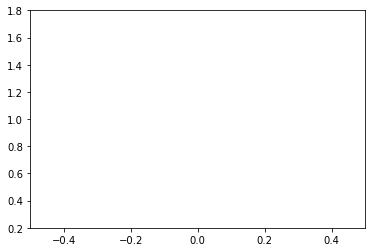

In [24]:
import matplotlib.pyplot as plt
import matplotlib.animation as ani
from IPython.display import HTML
%matplotlib inline

print(results.solver.status) 
print(results.solver.termination_condition) 

fig1, ax1 = plt.subplots(1,1) #create axes
#ax1.set_aspect('equal')

def plot_robot(i,m,ax): #update function for animation
    ax.clear()
    ax.set_xlim([-0.5,1])
    ax.set_ylim([0,1])
    
    #plot link 1
    link1_top_x = m.q0[i,'x'].value 
    link1_top_z = m.q0[i,'z'].value 
    link1_bottom_x = m.q0[i,'x'].value  + m.l1*np.sin(m.q0[i,'theta_1'].value)
    link1_bottom_z = m.q0[i,'z'].value  - m.l1*np.cos(m.q0[i,'theta_1'].value)  
    ax.plot([link1_top_x,link1_bottom_x],[link1_top_z,link1_bottom_z],color='xkcd:black')
    
    #plot link 2  
    link2_bottom_x = link1_bottom_x + m.l2*np.sin(m.q0[i,'theta_1'].value+m.q0[i,'theta_2'].value)
    link2_bottom_z = link1_bottom_z - m.l2*np.cos(m.q0[i,'theta_1'].value+m.q0[i,'theta_2'].value)
    ax.plot([link1_bottom_x,link2_bottom_x],[link1_bottom_z,link2_bottom_z],color='xkcd:red')
    
    #plot link 3
    link3_top_x = m.q0[i,'x'].value  
    link3_top_z = m.q0[i,'z'].value 
    link3_bottom_x = m.q0[i,'x'].value  + m.l3*sin(m.q0[i,'theta_3'].value)
    link3_bottom_z = m.q0[i,'z'].value  - m.l3*cos(m.q0[i,'theta_3'].value)  
    ax.plot([link3_top_x,link3_bottom_x],[link3_top_z,link3_bottom_z],color='xkcd:blue')
    
    #plot link 4  
    link4_bottom_x = link3_bottom_x + m.l4*sin(m.q0[i,'theta_3'].value+m.q0[i,'theta_4'].value)
    link4_bottom_z = link3_bottom_z - m.l4*cos(m.q0[i,'theta_3'].value+m.q0[i,'theta_4'].value)
    ax.plot([link3_bottom_x,link4_bottom_x],[link3_bottom_z,link4_bottom_z],color='xkcd:blue')
       
update = lambda i: plot_robot(i,m,ax1) #lambdify update function

animate = ani.FuncAnimation(fig1,update,range(1,N+1),interval = 50,repeat=False)

HTML(animate.to_jshtml())